In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download stopwords
nltk.download('stopwords')

# Load the dataset
print("Loading dataset...")
dataset_path = './IMDB Dataset.csv'  # Update the path to your dataset
data = pd.read_csv(dataset_path)

# Combine data: Assign labels (1 for positive, 0 for negative)
print("Assigning labels...")
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Text Cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

print("Cleaning text...")
data['review'] = data['review'].apply(clean_text)

# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split

print("Splitting dataset...")
x_train, x_test, y_train, y_test = train_test_split(
    data['review'], data['sentiment'], test_size=0.2, random_state=42
)

# Tokenization and Padding
print("Tokenizing and padding sequences...")
vocab_size = 20000  # Maximum number of words in the vocabulary
maxlen = 200        # Maximum length of input sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_train)  # Fit tokenizer on training data

# Convert text to sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Pad sequences to ensure uniform length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Summary of preprocessing
print(f"Vocabulary size: {vocab_size}")
print(f"Number of training samples: {len(x_train)}")
print(f"Number of testing samples: {len(x_test)}")

# Data is ready for training a model!

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading dataset...
Assigning labels...
Cleaning text...
Splitting dataset...
Tokenizing and padding sequences...
Vocabulary size: 20000
Number of training samples: 40000
Number of testing samples: 10000


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping

# Define hyperparameters
vocab_size = 20000  # Vocabulary size from the tokenizer
embedding_dim = 128  # Dimensionality of word embeddings
maxlen = 200  # Maximum length of input sequences
dropout_rate = 0.5  # Dropout rate to avoid overfitting
lstm_units = 64  # Number of LSTM units
gru_units = 64  # Number of GRU units

# Build the model
print("Building the model...")

model = Sequential([
    # Input layer: Embedding layer to learn dense vector representations
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),

    # Hidden layer: Choose between LSTM or GRU
    LSTM(lstm_units, return_sequences=False),  # Use GRU(gru_units) here if preferred

    # Dropout for regularization
    Dropout(dropout_rate),

    # Output layer: Dense layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model
print("Compiling the model...")
model.compile(
    loss='binary_crossentropy',  # Binary cross-entropy for binary classification
    optimizer='adam',  # Adam optimizer
    metrics=['accuracy']  # Accuracy as evaluation metric
)

# Display model summary
model.summary()

# Train the model
print("Training the model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=10,  # Adjust epochs as needed
    batch_size=64,  # Batch size for training
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[early_stopping]
)

# Evaluate the model
print("Evaluating the model...")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Building the model...
Compiling the model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2609473 (9.95 MB)
Trainable params: 2609473 (9.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Training the model...
Epoch 1/10
500/500 [==============================] - 93s 183ms/step - loss: 0.3611

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# Define training parameters
epochs = 10        # Number of epochs to train the model
batch_size = 64     # Batch size for training
validation_split = 0.2  # Use 20% of the training data for validation

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Stop training after 3 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

print("Training the model...")

# Train the model
history = model.fit(
    x_train, y_train,              # Training data and labels
    epochs=epochs,                 # Number of epochs
    batch_size=batch_size,         # Batch size
    validation_split=validation_split,  # Validation split
    callbacks=[early_stopping],    # Early stopping callback
    verbose=1                      # Display training progress
)

print("Training completed.")

Training the model...
Epoch 1/10
500/500 [==============================] - 103s 206ms/step - loss: 0.1940 - accuracy: 0.9292 - val_loss: 0.3273 - val_accuracy: 0.8779
Epoch 2/10
500/500 [==============================] - 105s 210ms/step - loss: 0.1268 - accuracy: 0.9562 - val_loss: 0.4334 - val_accuracy: 0.8731
Epoch 3/10
500/500 [==============================] - 100s 200ms/step - loss: 0.0998 - accuracy: 0.9655 - val_loss: 0.4259 - val_accuracy: 0.8676
Epoch 4/10
500/500 [==============================] - 95s 191ms/step - loss: 0.0598 - accuracy: 0.9804 - val_loss: 0.5332 - val_accuracy: 0.8577
Training completed.


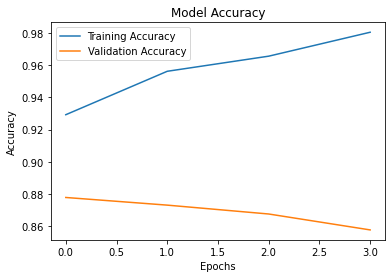

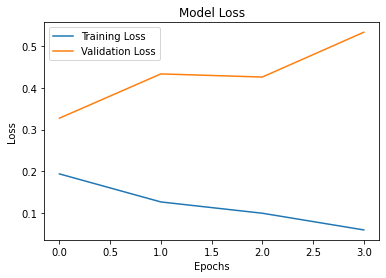

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
# Evaluate the model on the test dataset
print("Evaluating the model...")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating the model...
313/313 [==============================] - 11s 37ms/step - loss: 0.3013 - accuracy: 0.8834
Test Loss: 0.3013
Test Accuracy: 0.8834


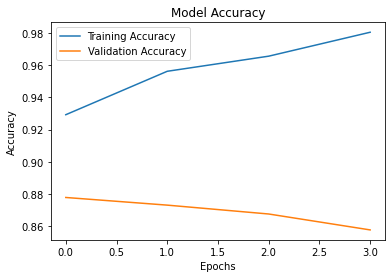

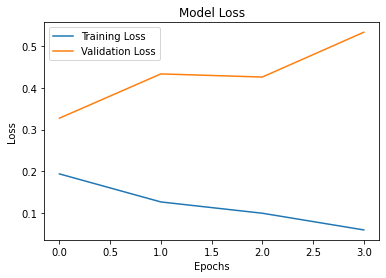

In [6]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Function to preprocess new reviews
def preprocess_review(review):
    # Text cleaning: convert to lowercase, remove special characters, etc.
    review = re.sub(r'<.*?>', '', review)  # Remove HTML tags
    review = re.sub(r'[^a-zA-Z\s]', '', review).lower()  # Remove special chars
    review = ' '.join(word for word in review.split() if word not in stopwords.words('english'))
    
    # Tokenize and pad the review
    review_seq = tokenizer.texts_to_sequences([review])
    review_padded = pad_sequences(review_seq, maxlen=maxlen)
    return review_padded

# Test with new reviews
new_reviews = [
    "The movie was fantastic! The characters were well-developed and the plot was engaging.",
    "I didn't enjoy the movie. The story was boring and the acting was terrible.",
    "It was an average movie, not great but not bad either."
]

print("Predicting sentiments for new reviews...")
for review in new_reviews:
    preprocessed_review = preprocess_review(review)
    prediction = model.predict(preprocessed_review)[0][0]  # Get the probability
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment} (Confidence: {prediction:.4f})\n")

Predicting sentiments for new reviews...
1/1 [==============================] - 1s 581ms/step
Review: The movie was fantastic! The characters were well-developed and the plot was engaging.
Sentiment: Positive (Confidence: 0.8397)

1/1 [==============================] - 0s 25ms/step
Review: I didn't enjoy the movie. The story was boring and the acting was terrible.
Sentiment: Negative (Confidence: 0.0322)

1/1 [==============================] - 0s 41ms/step
Review: It was an average movie, not great but not bad either.
Sentiment: Negative (Confidence: 0.3969)

